# Sparkify - Analyze Subset Dataset
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). This workspace explores a smaller subset with Spark before deploying your cluster on the cloud. 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime

# pyspark APIs
from pyspark.sql import SparkSession

from pyspark.sql.functions import avg, count, max, min, round, sum, udf, desc, isnan, countDistinct, when, col, trim
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler
from sklearn.metrics import confusion_matrix

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
# create a Spark session
spark = (SparkSession.builder 
                    .master("local") 
                    .appName("sparkify") 
                    .getOrCreate())

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Here the dataset is loaded and cleaned, checking for invalid or missing data - for example, records without userids or sessionids. 

In [8]:
events_df = spark.read.json('mini_sparkify_event_data.json')
events_df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [9]:
events_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
print((events_df.count(), len(events_df.columns)))

(286500, 18)


In [11]:
events_df.select([count(when(isnan(c), c)).alias(c) for c in events_df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



- Drop cells for 'userId','sessionId' that have null

In [12]:
events_df = events_df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [13]:
events_df.count()

286500

- No null in the datasets, how about the empty string for the columns?

In [14]:
events_df.filter((events_df['sessionId'] == '') | events_df['sessionId'].isNull() | isnan(events_df['sessionId'])).count()

0

In [15]:
events_df.filter((events_df['userId'] == '') | events_df['userId'].isNull() | isnan(events_df['userId'])).count()

8346

In [16]:
events_df.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



- By checking out the userid column, we can confirm that there seems contain value of empty string
- Let's filter them out

In [163]:
df = events_df

In [44]:
df.filter('page = "Cancellation Confirmation"').show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [164]:
def drop_missing(column,df=df):
    missing_count = df.filter((df[column] == '') | df[column].isNull() | isnan(df[column])).count()
    print('missing count:', missing_count)
    df = df.filter(df[column].isNotNull())
    df = df.filter(df[column] != '')
#     df = df.na.drop()
#     print(df.count())
    print('Done cleaning!')
    return df

In [165]:
df = drop_missing('userId')

missing count: 8346
Done cleaning!


In [166]:
df.count()

278154

- Finally, the datasets is 278154 rows and 18 columns

# Exploratory Data Analysis
Perform EDA by loading a small subset of the data and doing basic manipulations within Spark.

In [23]:
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154
1,mean,551.0852017937219,None,None,None,114.89918174824018,None,249.11718197783722,None,None,None,None,1.535358834085557E12,1042.5616241362698,Infinity,209.10321620397335,1.5409589154318577E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.85172939949013,None,99.23517921058324,None,None,None,None,3.291321616328068E9,726.5010362219821,NaN,30.151388851327823,1.5068287123347573E9,None,109091.94999910519
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10
4,max,ÃÂlafur Arnalds,Logged In,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


- Anyone who visit the cancellation page cancelled the subscription with Sparkify, which is churn that we are interested in. 
- Let's take a look into it. 

In [24]:
events_df.select('page').drop_duplicates().sort('page').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [25]:
events_df.select('page').groupby('page').count().orderBy(desc('count')).toPandas()

,page,count
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


In [26]:
events_df.select('auth').groupby('auth').count().orderBy(desc('count')).toPandas()

,auth,count
0,Logged In,278102
1,Logged Out,8249
2,Guest,97
3,Cancelled,52


### Define Churn

Once done some preliminary analysis, create a column `Churn` to use as the label for the model. `Cancellation Confirmation` events using to define your churn, which happen for both paid and free users. (a bonus task, you can also look into the `Downgrade` events.)

- We are also interested in the user ids before and after certain event. 
- For example, let's look into the user ids of cancellation process and create a column for it

In [48]:
df.filter('page = "Cancellation Confirmation"').show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [167]:
flag_cancell_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [168]:
df = df.withColumn('Churn', flag_cancell_event('page'))  # create a new column indicating the user has churned

In [169]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)

### Explore Data
perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### 1. How many songs the users (churn/not churn) listening in the particular hour 

In [170]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [171]:
df = df.withColumn('hour', get_hour(df.ts))

In [55]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, hour='20'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', Churn=0, hour='20'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', l

In [172]:
songs_in_hour_0 = df.filter(df.Churn == 0).groupby(df.hour).agg({'hour':'count'}).orderBy(df.hour.cast("float"))
songs_in_hour_0.show(5)

+----+-----------+
|hour|count(hour)|
+----+-----------+
|   0|       9983|
|   1|       9908|
|   2|       9772|
|   3|       9911|
|   4|      10074|
+----+-----------+
only showing top 5 rows



In [173]:
#songs_in_hour_1 = df.filter(df.Churn == 1).groupby(df.hour).count().orderBy(df.hour.cast("float"))
songs_in_hour_1 = df.filter(df.Churn == 1).groupby(df.hour).agg({'hour':'count'}).orderBy(df.hour.cast("float"))
songs_in_hour_1.show(5)

+----+-----------+
|hour|count(hour)|
+----+-----------+
|   0|          2|
|   1|          1|
|   2|          2|
|   3|          5|
|   6|          3|
+----+-----------+
only showing top 5 rows



In [146]:
#hour_songs = songs_in_hour_1.join(songs_in_hour_0,on=['hour'], how='inner')
#hour_songs.show(5)

In [174]:
songs_in_hour_pd_0 = songs_in_hour_0.toPandas()
songs_in_hour_pd_0.hour = pd.to_numeric(songs_in_hour_pd_0.hour)
print(songs_in_hour_pd_0)

    hour  count(hour)
0      0         9983
1      1         9908
2      2         9772
3      3         9911
4      4        10074
5      5        10359
6      6        10559
7      7        11293
8      8        11644
9      9        12303
10    10        13195
11    11        13931
12    12        14253
13    13        13867
14    14        13427
15    15        13348
16    16        13214
17    17        12456
18    18        12059
19    19        11490
20    20        10817
21    21        10086
22    22        10078
23    23        10075


In [175]:
songs_in_hour_pd_1 = songs_in_hour_1.toPandas()
songs_in_hour_pd_1.hour = pd.to_numeric(songs_in_hour_pd_1.hour)
print(songs_in_hour_pd_1)

    hour  count(hour)
0      0            2
1      1            1
2      2            2
3      3            5
4      6            3
5      7            1
6      8            1
7      9            2
8     10            1
9     11            5
10    12            2
11    13            2
12    14            5
13    15            4
14    16            3
15    17            3
16    18            2
17    19            2
18    20            2
19    21            1
20    22            1
21    23            2


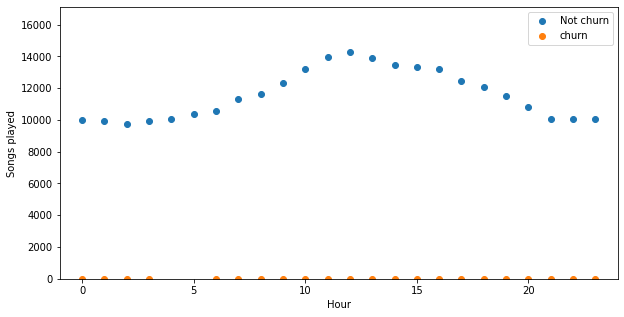

In [150]:
plt.figure(figsize =(10,5))

churn_0 = plt.scatter(songs_in_hour_pd_0["hour"], songs_in_hour_pd_0["count"])
churn_1 = plt.scatter(songs_in_hour_pd_1["hour"], songs_in_hour_pd_1["count"])
plt.xlim(-1, 24)
plt.ylim(-1, 1.2 * songs_in_hour_pd_0["count"].max())
plt.legend((churn_0,churn_1),('Not churn','churn'))
plt.xlabel("Hour")
plt.ylabel("Songs played");

- In this case, we can see not churn users play songs much more than the users who churn.

#### 2.  Average length of songs played by the users (churn/not churn)

In [208]:
def getAvgLen4Group(churnFlag, df = df):
    churn_id = df.filter(df.Churn == churnFlag).toPandas()['userId'].values
    churn_id_set = set(churn_id)
    
    df_id_length = df.select(['userid', 'length'])
    length = 0
    for row in df_id_length.rdd.collect():
        if(row.length and row.userid in churn_id_set):
             length += row.length

    return length / len(churn_id_set)

In [209]:
getAvgLen4Group(1)

174014.26855134717

In [210]:
getAvgLen4Group(0)

252558.32065156646

In [217]:
data = {'churn_type':[0,1],'average_length':[getAvgLen4Group(0),getAvgLen4Group(1)]}
avglen4Group_df = pd.DataFrame(data, columns = ['churn_type','average_length'])
avglen4Group_df

,churn_type,average_length
0,0,252558.320652
1,1,174014.268551


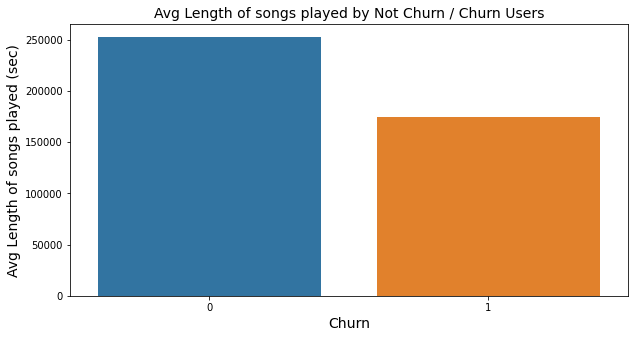

In [228]:
plt.figure(figsize =(10,5))

sb.barplot(x = 'churn_type', y='average_length', data=avglen4Group_df);
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Avg Length of songs played (sec)', fontsize=14);
plt.title('Avg Length of songs played by Not Churn / Churn Users', fontsize=14);

- For Avg length of listening to the song, the un-churned users are way longer than churned

#### 3.  Churn rate VS userAgent used

In [314]:
usersys_func = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

In [312]:
usersys_df = df.withColumn('userAgent', usersys_func(df['userAgent']))
usersys_df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Windows', userId='30', Churn=0, hour='20'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='Windows', userId='9', Churn=0, hour='20')]

In [459]:
useragent_churn_df = usersys_df.select(['userId', 'userAgent', 'churn']).dropDuplicates()\
            .groupBy('userAgent').agg(count('userId').alias('num_users'), sum('churn').alias('num_churns'))

In [466]:
useragent_churn_df_pd = useragent_churn_df.toPandas()
useragent_churn_df_pd

,userAgent,num_users,num_churns
0,iPad,3,0
1,X11,17,5
2,iPhone,17,4
3,Macintosh,105,19
4,compatible,5,0
5,Windows,130,24


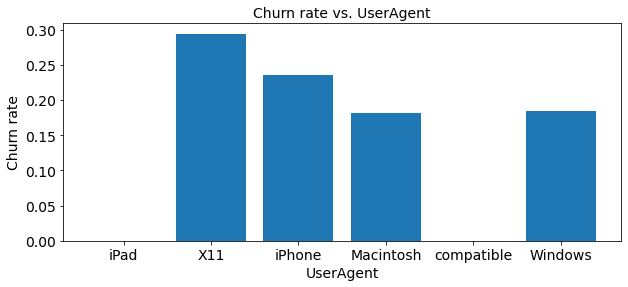

In [462]:
plt.figure(figsize=(10,4))
plt.bar(useragent_churn_df_pd['userAgent'], useragent_churn_df_pd['num_churns'] / useragent_churn_df_pd['num_users'])

plt.xlabel("UserAgent", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Churn rate vs. UserAgent", fontsize=14);

- We can see from the figure above that X11 have the most churn rate, also the iphone, 
- The agent service can take a look into those to improve the customer experience specificly

In [467]:
#from collections import defaultdict
#churn_useragent_dic = defaultdict(int)
#useragent_churn_pd_df = useragent_churn_df.toPandas()

#for i in useragent_churn_df.collect():
#    agent = i.userAgent
#    total_users = useragent_churn_pd_df.query('userAgent == @agent')['count(userId)'].sum()
#     churned_users = useragent_churn_pd_df.query('userAgent == @agent').query('Churn == 1').iloc[0,2]
#     print(churned_users / total_users)
    

#### 4.

In [282]:
useid_page_df = df.groupby(['userId']).pivot('page').count().toPandas().fillna(0)

In [283]:
useid_page_df.rename(columns={'Cancellation Confirmation': 'Churn'}, inplace = True)
useid_page_df

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3.0,4.0,8.0,0.0,0.0,5.0,0.0,2.0,20.0,5.0,387,7.0,0.0,3.0,0.0,1.0,6.0,21.0,2.0
1,100010,1.0,4.0,7.0,0.0,0.0,0.0,0.0,2.0,11.0,5.0,275,52.0,0.0,0.0,0.0,0.0,5.0,17.0,2.0
2,125,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51,2.0,28.0,52.0,1.0,1.0,23.0,1.0,12.0,75.0,24.0,2111,0.0,1.0,12.0,0.0,0.0,21.0,100.0,0.0
4,124,7.0,74.0,118.0,0.0,0.0,41.0,6.0,23.0,176.0,59.0,4079,4.0,6.0,20.0,0.0,0.0,41.0,171.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,92,6.0,1.0,1.0,0.0,0.0,2.0,3.0,0.0
221,45,3.0,22.0,43.0,0.0,0.0,18.0,0.0,5.0,65.0,19.0,1484,13.0,4.0,15.0,0.0,1.0,13.0,67.0,4.0
222,200021,3.0,19.0,30.0,1.0,1.0,26.0,1.0,4.0,54.0,20.0,1227,11.0,2.0,9.0,0.0,1.0,35.0,55.0,3.0
223,119,1.0,4.0,5.0,0.0,0.0,0.0,1.0,3.0,11.0,2.0,173,9.0,1.0,3.0,0.0,0.0,1.0,7.0,2.0


In [286]:
plot_columns = useid_page_df.drop('Churn', axis = 1).columns
plot_columns

Index(['userId', 'About', 'Add Friend', 'Add to Playlist', 'Cancel',
       'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong',
       'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade',
       'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade'],
      dtype='object')

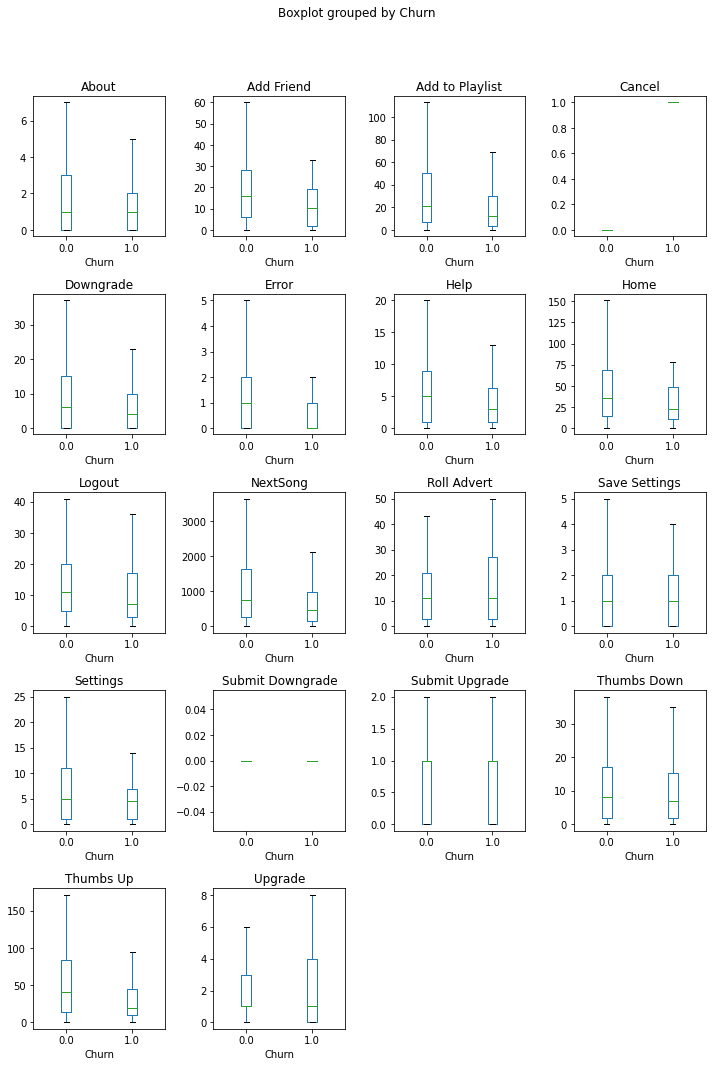

In [288]:
fig = plt.figure(figsize=(10, 18))

for i in range(1,len(plot_columns)):
    axis = fig.add_subplot(6,4,i)
    useid_page_df.boxplot(plot_columns[i], ax = axis, grid = False,  by='Churn', showfliers=False)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [302]:
corrMatrix = useid_page_df.corr()
corrMatrix

,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
About,1.000000,0.756170,0.781100,-0.197811,-0.197811,0.733903,0.471889,0.723991,0.774379,0.748116,0.782108,0.291010,0.494660,0.735887,0.371106,0.450831,0.686084,0.775240,0.368700
Add Friend,0.756170,1.000000,0.929507,-0.180956,-0.180956,0.859250,0.667941,0.889177,0.934844,0.919733,0.946730,0.367850,0.647334,0.855644,0.461898,0.580953,0.823676,0.902834,0.428851
Add to Playlist,0.781100,0.929507,1.000000,-0.151875,-0.151875,0.907773,0.681602,0.928972,0.970919,0.944485,0.986427,0.343019,0.639875,0.896953,0.453175,0.565297,0.831258,0.939989,0.400942
Cancel,-0.197811,-0.180956,-0.151875,1.000000,1.000000,-0.124208,-0.188287,-0.141573,-0.147023,-0.132591,-0.156110,0.028459,-0.083063,-0.120900,-0.099973,-0.068345,-0.074668,-0.168105,-0.013730
Churn,-0.197811,-0.180956,-0.151875,1.000000,1.000000,-0.124208,-0.188287,-0.141573,-0.147023,-0.132591,-0.156110,0.028459,-0.083063,-0.120900,-0.099973,-0.068345,-0.074668,-0.168105,-0.013730
Downgrade,0.733903,0.859250,0.907773,-0.124208,-0.124208,1.000000,0.649847,0.873665,0.919348,0.898380,0.929950,0.296489,0.673025,0.868210,0.426362,0.537482,0.836950,0.818785,0.335230
Error,0.471889,0.667941,0.681602,-0.188287,-0.188287,0.649847,1.000000,0.659052,0.699953,0.660163,0.706660,0.150245,0.465971,0.583134,0.316944,0.396235,0.595875,0.670309,0.207496
Help,0.723991,0.889177,0.928972,-0.141573,-0.141573,0.873665,0.659052,1.000000,0.931481,0.909744,0.941136,0.369635,0.624541,0.867738,0.456135,0.560651,0.788749,0.889711,0.413738
Home,0.774379,0.934844,0.970919,-0.147023,-0.147023,0.919348,0.699953,0.931481,1.000000,0.979852,0.986356,0.442752,0.666705,0.900499,0.500650,0.600829,0.856326,0.916201,0.471976
Logout,0.748116,0.919733,0.944485,-0.132591,-0.132591,0.898380,0.660163,0.909744,0.979852,1.000000,0.964499,0.497911,0.629359,0.864041,0.526056,0.603029,0.867002,0.880720,0.501462


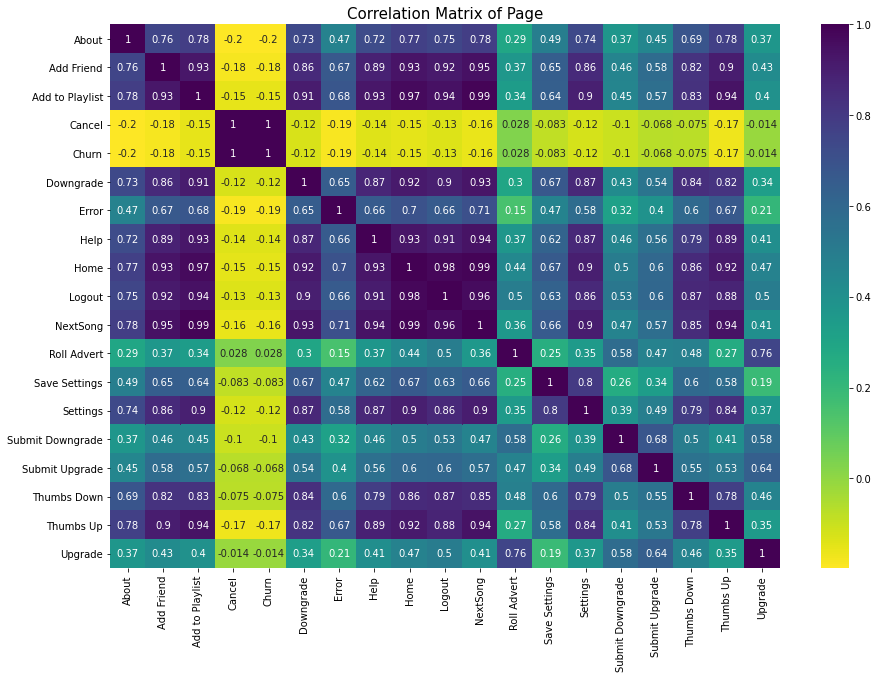

In [303]:
fig = plt.figure(figsize=(15, 10))
sb.heatmap(corrMatrix, annot=True,cmap = 'viridis_r')
plt.title('Correlation Matrix of Page', fontsize=15)
plt.show()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.